<a href="https://colab.research.google.com/github/tamtran4869/media_effectiveness_analysis/blob/main/MTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-touch Attribution (MTA)

While the marketing mix model (MMM) uses time series of media data to compute contribution of each channels into the KPI, multi-touch attribution (MTA) uses customer journey data to do that.

So MTA requires data in individual level and normally is used for digita media(website, email marketing...) where we can track audience by cookies or user id.


## Install and import packages

In [1]:
#Install and import packages
!pip install --upgrade pip
!pip install ChannelAttribution
!pip install marketing_attribution_models

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px

from ChannelAttribution import *
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import itertools
from collections import defaultdict
from itertools import permutations,combinations
%matplotlib inline

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Version: 2.1.4


## Load and preprocess data

Besides preprocessing, it's important to sort the data by `date_served` to maintain the correct order of the path/journey.

In [2]:
#Importing the data
url='https://drive.google.com/file/d/15qu2NZF2calUgbPM4ho52E_ziJZKwWLp/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

#Preprocessing data
df = df[['user_id', 'date_served','marketing_channel','converted']]
df = df.dropna()
df = df.drop_duplicates()
df['date_served'] = pd.to_datetime(df['date_served'])
df['converted'] = df['converted'].astype('int')
df = df.sort_values(by='date_served',axis =0,ignore_index=True)
df.head()

,user_id,date_served,marketing_channel,converted
0,a100000029,2018-01-01,House Ads,1
1,a100004324,2018-01-01,House Ads,0
2,a100004323,2018-01-01,House Ads,0
3,a100004322,2018-01-01,House Ads,0
4,a100004321,2018-01-01,House Ads,0


## EDA
Quick look at channel conversion over time.

In [3]:
#Plotting conversions over time by channel
conversions = df.loc[df['converted'] == 1]
conversions.drop(columns = ['user_id'], inplace = True)
conversions = conversions.groupby(['date_served','marketing_channel'], as_index=False).sum()

fig = px.line(conversions, x='date_served', y='converted', color='marketing_channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Date',
                   yaxis_title='Conversions')
fig.show()

- House Ads had a strong start in the first 1.5 weeks, but then experienced a significant decline and remained stable for the rest of the month.
- Facebook and Instagram showed similar and higher conversion rates compared to Email and Push.
- Apart from House Ads, there was a notable surge in activity across all channels between January 14th and 19th, particularly in Email.
- After the spikes, everything settled into a stable state with a slight decrease compared to the period before the spikes.

In [4]:
# Overal conversions
print('Total conversions: {}'.format(sum(df.converted)))
print('Total conversion rate: {}%'.format(round(sum(df.converted) / len(df)*100)))

Total conversions: 1035
Total conversion rate: 10%


## Transform data

We need transform data from user level to journey level though 3 steps:
- Step 1: Group users and concat channels -> dataframe with 1 row per user


In [5]:
# Group channels by user_id
df_paths = df.groupby('user_id')['marketing_channel'].aggregate(
    lambda x: ','.join(x.unique().tolist()))

df_last_interaction = df.drop_duplicates('user_id', keep='last')[['user_id', 'converted']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='user_id')
df_paths[df_paths.user_id=='a100000882']


,user_id,marketing_channel,converted
881,a100000882,"House Ads,Instagram",1


- Step 2: From the concatenated channels, convert them into paths and add null columns for users who did not make conversions. Additionally, remove the `user_id` column.

In [6]:
# Create path and null columns
df_paths['path'] = df_paths['marketing_channel'].apply(lambda x: x.replace(',','>'))
df_paths.drop(columns = 'user_id', inplace = True)
df_paths['null'] = np.where(df_paths['converted'] == 0,1,0)
df_paths[df_paths['marketing_channel']=='House Ads,Instagram']

,marketing_channel,converted,path,null
206,"House Ads,Instagram",0,House Ads>Instagram,1
207,"House Ads,Instagram",0,House Ads>Instagram,1
213,"House Ads,Instagram",0,House Ads>Instagram,1
214,"House Ads,Instagram",0,House Ads>Instagram,1
424,"House Ads,Instagram",0,House Ads>Instagram,1
...,...,...,...,...
6796,"House Ads,Instagram",0,House Ads>Instagram,1
6798,"House Ads,Instagram",0,House Ads>Instagram,1
6800,"House Ads,Instagram",0,House Ads>Instagram,1
6802,"House Ads,Instagram",0,House Ads>Instagram,1


- Step 3: Group by `path` and sum conversions and null. Besides, rename columns -> dataframe with 1 unique path per row.

In [7]:
# Group by path, marketing channel
attribution_df = df_paths.groupby(['path','marketing_channel'],as_index = False).sum()
attribution_df.rename(columns={"converted": "total_conversions", "null": "total_null","marketing_channel":'channels_subset'}, inplace = True)
attribution_df.head()

,path,channels_subset,total_conversions,total_null
0,Email,Email,110,159
1,Email>Facebook,"Email,Facebook",0,23
2,Email>House Ads,"Email,House Ads",0,44
3,Email>House Ads>Facebook,"Email,House Ads,Facebook",0,3
4,Email>House Ads>Instagram,"Email,House Ads,Instagram",0,2


# MTA

- Rule-based model: credits channels by predefined rules. For example: all credit for `first touch`, all credit for `last touch`, equal credit for all channels (`linear`), higher credit for first and last touch (`position_based`), or credit decay by time (`time_decay`)
- Game theory with shapley values: This approach takes into cooperation between channels into account and credits for each channel based on its contribution into cooperations.
A very clear example is in https://medium.com/data-from-the-trenches/marketing-attribution-e7fa7ae9e919
- Markov chain: credits channels by how channels affect the probablity of conversions with transition matrix (https://towardsdatascience.com/into-to-markov-chain-multi-touch-attribution-bb1968ff1f54)

In [8]:
#Rule-based model (first touch, last touch and linear models)
H=heuristic_models(attribution_df,"path","total_conversions")
H

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,first_touch,last_touch,linear_touch
0,Email,110.0,151.0,129.833333
1,Facebook,128.0,166.0,148.333333
2,House Ads,461.0,301.0,379.000000
3,Instagram,77.0,148.0,112.500000
4,Push,51.0,61.0,57.333333


In [9]:
# Rule-based model: position based model
def position_based(dat, r: tuple[float, float] = (40, 40)):
  '''
  This function returns a dataframe of distributed conversions by channels using rate r.
  Rate r default is 40% for first touch, 40% for last touch and 20% for the middle touchpoints.
  '''
  position_based = defaultdict(float)
  for row in dat.itertuples():
    lst = row.path.split('>')
    if row.total_conversions:
      n = len(set(lst))
      if n == 1:
        position_based[lst[-1]] += row.total_conversions
      elif n == 2:
        equal_share = row.total_conversions / n
        position_based[lst[0]] += equal_share
        position_based[lst[-1]] += equal_share
      else:
        position_based[lst[0]] += (r[0] * row.total_conversions / 100)
        position_based[lst[-1]] += (r[1] * row.total_conversions /100)
        for c in lst[1:-1]:
          position_based[c] += ((100 - sum(r)) * row.total_conversions / (n - 2) / 100)
  return pd.DataFrame.from_dict(position_based,orient='index',columns=['position_based']).reset_index().rename(columns={'index': 'channel_name'})

P = position_based(attribution_df)
P

,channel_name,position_based
0,Email,130.1
1,Facebook,147.8
2,House Ads,379.8
3,Instagram,112.5
4,Push,56.8


In [10]:
# Rule-based model: Time decay
def time_decay(dat, count_direction: str = "left"):
  '''
  This function returns a dataframe of distributed conversions by channels using time decay
  '''
  time_decay = defaultdict(float)
  if count_direction not in "left right".split():
    raise ValueError("argument count_direction must be *left* or *right*!")

  for row in dat.itertuples():
    if row.total_conversions:
      channels_by_exp_time = []
      _ = row.path.split('>') if count_direction == "left" else row.path[::-1].split('>')
      for c in _:
        if c not in channels_by_exp_time:
          channels_by_exp_time.append(c)
          if count_direction == "right":
            channels_by_exp_time = channels_by_exp_time[::-1]

      score_unit = 1.0 / sum(range(1, len(channels_by_exp_time) + 1))
      for i, c in enumerate(channels_by_exp_time, 1):
        time_decay[c] += i * score_unit * row.total_conversions

  return pd.DataFrame.from_dict(time_decay,orient='index',columns=['time_decay']).reset_index().rename(columns={'index': 'channel_name'})

T = time_decay(attribution_df)
T

,channel_name,time_decay
0,Email,136.666667
1,Facebook,154.666667
2,House Ads,352.333333
3,Instagram,124.333333
4,Push,59.000000


In [11]:
def calculate_shapley(df, col_name):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channels_subset', 'conversion_sum'].
            The channel_subset column is the channel(s) associated with the conversion and the count is the sum of the conversions.
            - col_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. Email,PPC and PPC,Email are the same
            in regards to this analysis and should be combined under Email,PPC.
            ***Be careful with the distinct number of channels because this can signifcantly slow the perfomance of this function.
            Remember the total possible combinations of channels is 2^(n) where n is the number of channels. If you have 30 channels
            this is 1,073,741,824 combinations.
    '''
    def power_set(List):
      PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
      return PS

    def subsets(s):
        '''
        This function returns all the possible subsets of a set of channels.
        input :
                - s: a set of channels.
        '''
        if len(s)==1:
            return s
        else:
            sub_channels=[]
            for i in range(1,len(s)+1):
                sub_channels.extend(map(list,itertools.combinations(s, i)))
        return list(map(",".join,map(sorted,sub_channels)))

    def v_function(A,C_values):
        '''
        This function computes the worth of each coalition.
        inputs:
                - A : a coalition of channels.
                - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
        '''
        subsets_of_A = subsets(A)
        #print(subsets_of_A)
        #exit()
        worth_of_A=0
        for subset in subsets_of_A:
            #print("subset:", subset)
            if subset in C_values:
                #print("subset:", subset, "; Value:", C_values[subset])
                worth_of_A += C_values[subset]
        return worth_of_A

    def factorial(n):
        if n == 0:
            return 1
        else:
            return n * factorial(n-1)

    c_values = df.set_index("channels_subset").to_dict()[col_name]
    df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())

    v_values = {}
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    #print(v_values)
    n=len(channels)
    shapley_values = defaultdict(int)
    for channel in channels:
            for A in v_values.keys():
                #print(A)
                if channel not in A.split(","):
                    #print(channel)
                    cardinal_A=len(A.split(","))
                    A_with_channel = A.split(",")
                    A_with_channel.append(channel)
                    A_with_channel=",".join(sorted(A_with_channel))
                    # Weight = |S|!(n-|S|-1)!/n!
                    weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                    # Marginal contribution = v(S U {i})-v(S)
                    contrib = (v_values[A_with_channel]-v_values[A])
                    shapley_values[channel] += weight * contrib
            # Add the term corresponding to the empty set
            shapley_values[channel]+= v_values[channel]/n
    return pd.DataFrame.from_dict(shapley_values,orient='index',columns=['shapley_values']).reset_index().rename(columns={'index': 'channel_name'})

S = calculate_shapley(attribution_df[['channels_subset','total_conversions']],'total_conversions')
S

,channel_name,shapley_values
0,Email,110.000000
1,Facebook,102.333333
2,House Ads,329.833333
3,Instagram,86.833333
4,Push,39.000000


In [12]:
#Markov model
M=markov_model(attribution_df, "path", var_conv="total_conversions",var_null='total_null', order=1, sep='>',ncore=1,out_more=True,verbose=True)
M['result']

Number of simulations: 100000 - Reaching convergence (wait...): 5.80% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 5.32% > 5.00%
Number of simulations: 225000 - Convergence reached: 4.67% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (5) is reached: 99.97%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,total_conversions
0,Email,132.522324
1,Facebook,167.929052
2,House Ads,308.923700
3,Instagram,150.731498
4,Push,66.893425


In [13]:
# Merge models
R = pd.concat(
    objs=(iDF.set_index('channel_name') for iDF in (H,P,T, S,M['result'])),
    axis=1,
    join='inner'
).reset_index().rename(columns={'total_conversions':'markov_chains'})
R

,channel_name,first_touch,last_touch,linear_touch,position_based,time_decay,shapley_values,markov_chains
0,Email,110.0,151.0,129.833333,130.1,136.666667,110.000000,132.522324
1,Facebook,128.0,166.0,148.333333,147.8,154.666667,102.333333,167.929052
2,House Ads,461.0,301.0,379.000000,379.8,352.333333,329.833333,308.923700
3,Instagram,77.0,148.0,112.500000,112.5,124.333333,86.833333,150.731498
4,Push,51.0,61.0,57.333333,56.8,59.000000,39.000000,66.893425


In [14]:
# Plot model results
R_melt=pd.melt(R, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R_melt.channel_name, y = R_melt.value,
             transforms = [dict(type = "groupby", groups = R_melt.variable,)])]

pio.show(dict({"data":data}),validate=False)

In [15]:
# Get transition matrix
transition_matrix = transition_matrix(attribution_df.drop('channels_subset',axis = 1), "path", "total_conversions", var_null="total_null")
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, '(conversion)'),
  Text(1.5, 0, '(null)'),
  Text(2.5, 0, 'Email'),
  Text(3.5, 0, 'Facebook'),
  Text(4.5, 0, 'House Ads'),
  Text(5.5, 0, 'Instagram'),
  Text(6.5, 0, 'Push')])

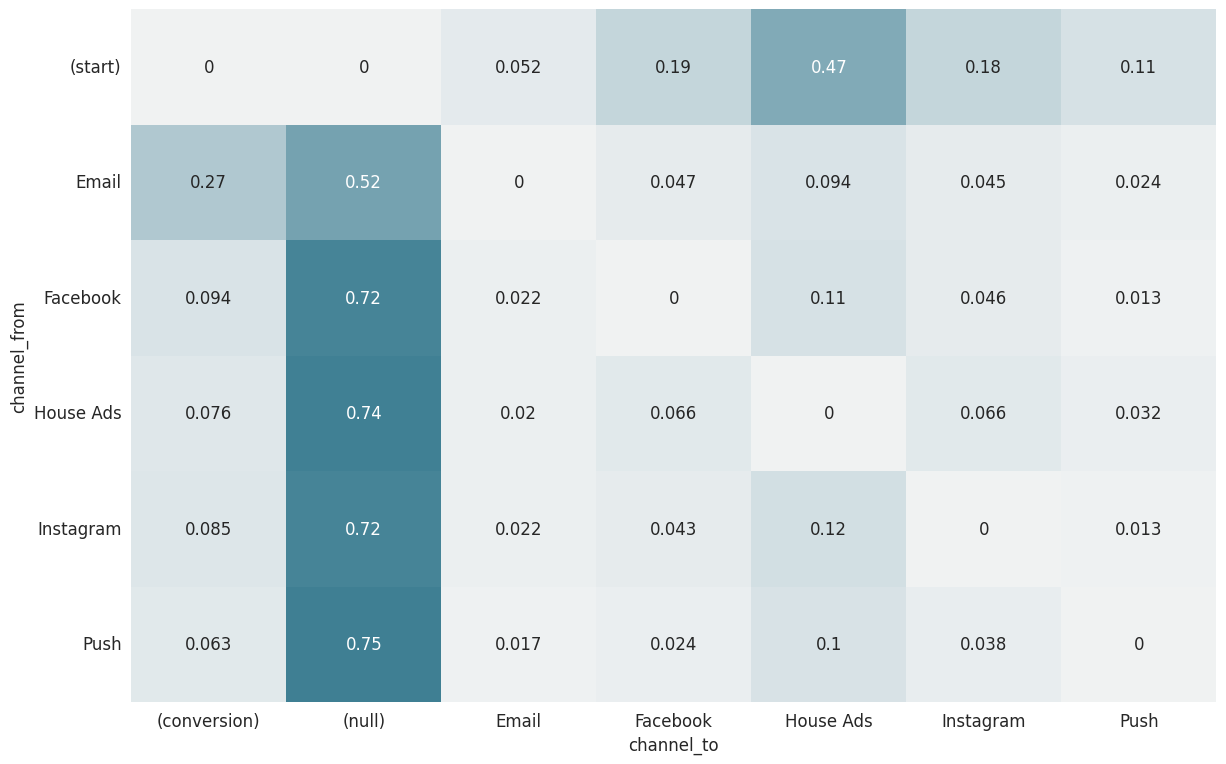

In [16]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

With the transition matrix, it is possible to compute conversion or non-conversion probability of any journey.
For example: we have the path House Ads > Instagram > Conversion, then the conversion probability is 0.066 * 0.085 = 0.00561


## REFERENCES:
https://github.com/eeghor/mta/blob/master/mta/mta.py

https://medium.com/analytics-vidhya/the-shapley-value-approach-to-multi-touch-attribution-marketing-model-e345b35f3359#:~:text=In%20game%20theory%2C%20the%20Shapley,other%20to%20obtain%20the%20payoff.

https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling

https://medium.com/data-from-the-trenches/marketing-attribution-e7fa7ae9e919

https://towardsdatascience.com/into-to-markov-chain-multi-touch-attribution-bb1968ff1f54
